# Detecting Seizure with SPaRCNet

classify windows into 6 classes:

1. SZ
2. LPD
3. GPD
4. LRDA
5. GRDA
6. other

# load config and model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hdf5storage
import numpy as np
from mne.filter import filter_data, notch_filter
import time
import numpy as np
import random
import re
import torch.nn as nn
import statsmodels.api as sm
import pandas as pd
from collections import OrderedDict
import torch

import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import os
from utils_sparcnet import get_iEEG_data, preprocess, get_onset_and_spread
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## state model

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from collections import OrderedDict

class _DenseLayer(nn.Sequential):
	def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, conv_bias, batch_norm):
		super(_DenseLayer, self).__init__()
		if batch_norm:
			self.add_module('norm1', nn.BatchNorm1d(num_input_features)),
		# self.add_module('relu1', nn.ReLU()),
		self.add_module('elu1', nn.ELU()),
		self.add_module('conv1', nn.Conv1d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=conv_bias)),
		if batch_norm:
			self.add_module('norm2', nn.BatchNorm1d(bn_size * growth_rate)),
		# self.add_module('relu2', nn.ReLU()),
		self.add_module('elu2', nn.ELU()),
		self.add_module('conv2', nn.Conv1d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=conv_bias)),
		# self.add_module('conv2', nn.Conv1d(bn_size * growth_rate, growth_rate, kernel_size=7, stride=1, padding=3, bias=conv_bias)),
		self.drop_rate = drop_rate

	def forward(self, x):
		# print("Dense Layer Input: ")
		# print(x.size())
		new_features = super(_DenseLayer, self).forward(x)
		# print("Dense Layer Output:")
		# print(new_features.size())
		if self.drop_rate > 0:
			new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
		return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
	def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, conv_bias, batch_norm):
		super(_DenseBlock, self).__init__()
		for i in range(num_layers):
			layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate, conv_bias, batch_norm)
			self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
	def __init__(self, num_input_features, num_output_features, conv_bias, batch_norm):
		super(_Transition, self).__init__()
		if batch_norm:
			self.add_module('norm', nn.BatchNorm1d(num_input_features))
		# self.add_module('relu', nn.ReLU())
		self.add_module('elu', nn.ELU())
		self.add_module('conv', nn.Conv1d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=conv_bias))
		self.add_module('pool', nn.AvgPool1d(kernel_size=2, stride=2))


class DenseNetEnconder(nn.Module):
	def __init__(self, growth_rate=32, block_config=(4, 4, 4, 4, 4, 4, 4),  #block_config=(6, 12, 24, 48, 24, 20, 16),  #block_config=(6, 12, 24, 16),
				 in_channels=16, num_init_features=64, bn_size=4, drop_rate=0.2, conv_bias=True, batch_norm=False):

		super(DenseNetEnconder, self).__init__()

		# First convolution
		first_conv = OrderedDict([('conv0', nn.Conv1d(in_channels, num_init_features, kernel_size=7, stride=2, padding=3, bias=conv_bias))])
		# first_conv = OrderedDict([('conv0', nn.Conv1d(in_channels, num_init_features, groups=in_channels, kernel_size=7, stride=2, padding=3, bias=conv_bias))])
		# first_conv = OrderedDict([('conv0', nn.Conv1d(in_channels, num_init_features, kernel_size=15, stride=2, padding=7, bias=conv_bias))])

		# first_conv = OrderedDict([
		# 	('conv0-depth', nn.Conv1d(in_channels, 32, groups=in_channels, kernel_size=7, stride=2, padding=3, bias=conv_bias)),
		# 	('conv0-point', nn.Conv1d(32, num_init_features, kernel_size=1, stride=1, bias=conv_bias)),
		# ])

		if batch_norm:
			first_conv['norm0'] = nn.BatchNorm1d(num_init_features)
		# first_conv['relu0'] = nn.ReLU()
		first_conv['elu0'] = nn.ELU()
		first_conv['pool0'] = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

		self.densenet = nn.Sequential(first_conv)

		num_features = num_init_features
		for i, num_layers in enumerate(block_config):
			block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
								bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate, conv_bias=conv_bias, batch_norm=batch_norm)
			self.densenet.add_module('denseblock%d' % (i + 1), block)
			num_features = num_features + num_layers * growth_rate
			if i != len(block_config) - 1:
				trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2, conv_bias=conv_bias, batch_norm=batch_norm)
				self.densenet.add_module('transition%d' % (i + 1), trans)
				num_features = num_features // 2

		# Final batch norm
		if batch_norm:
			self.densenet.add_module('norm{}'.format(len(block_config) + 1), nn.BatchNorm1d(num_features))
		# self.features.add_module('norm5', BatchReNorm1d(num_features))

		self.densenet.add_module('relu{}'.format(len(block_config) + 1), nn.ReLU())
		self.densenet.add_module('pool{}'.format(len(block_config) + 1), nn.AvgPool1d(kernel_size=7, stride=3))  # stride originally 1

		self.num_features = num_features

		# Official init from torch repo.
		for m in self.modules():
			if isinstance(m, nn.Conv1d):
				nn.init.kaiming_normal_(m.weight.data)
			elif isinstance(m, nn.BatchNorm1d):
				m.weight.data.fill_(1)
				m.bias.data.zero_()
			elif isinstance(m, nn.Linear):
				m.bias.data.zero_()

	def forward(self, x):
		features = self.densenet(x)
		# print("Final Output")
		# print(features.size())
		return features.view(features.size(0), -1)


class DenseNetClassifier(nn.Module):
	# def __init__(self, growth_rate=16, block_config=(3, 6, 12, 8),  #block_config=(6, 12, 24, 48, 24, 20, 16),  #block_config=(6, 12, 24, 16),
	# 			 in_channels=16, num_init_features=32, bn_size=2, drop_rate=0, conv_bias=False, drop_fc=0.5, num_classes=6):
	def __init__(self, growth_rate=32, block_config=(4, 4, 4, 4, 4, 4, 4),
				 in_channels=16, num_init_features=64, bn_size=4, drop_rate=0.2, conv_bias=True, batch_norm=False, drop_fc=0.5, num_classes=6):

		super(DenseNetClassifier, self).__init__()

		self.features = DenseNetEnconder(growth_rate=growth_rate, block_config=block_config, in_channels=in_channels,
										 num_init_features=num_init_features, bn_size=bn_size, drop_rate=drop_rate,
										 conv_bias=conv_bias, batch_norm=batch_norm)

		# Linear layer
		self.classifier = nn.Sequential(
			nn.Dropout(p=drop_fc),
			nn.Linear(self.features.num_features, num_classes)
		)

		# Official init from torch repo.
		for m in self.modules():
			if isinstance(m, nn.Conv1d):
				nn.init.kaiming_normal_(m.weight.data)
			elif isinstance(m, nn.BatchNorm1d):
				m.weight.data.fill_(1)
				m.bias.data.zero_()
			elif isinstance(m, nn.Linear):
				m.bias.data.zero_()

	def forward(self, x):
		features = self.features(x)
		out = self.classifier(features)
		return out, features


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_cnn = torch.load("sparcnet_pretrain.pt", weights_only=False)

# one seizure example

## preprocessing

In [5]:
from utils_sparcnet import get_iEEG_data, preprocess
seizure_list = pd.read_csv('/mnt/sauce/littlab/users/kuangzy/SeizureOnsetDetection/revised_emu_seizure_sheet.csv')
sz_row = seizure_list.iloc[0,:]
print(f"Pulling seizure from {sz_row.patient}: {sz_row.fname} from {sz_row.start} to {sz_row.end}")
sz_df, fs_raw = get_iEEG_data('joie1','/mnt/sauce/littlab/users/kuangzy/ieeglogin.bin',
                              sz_row.fname,sz_row.start*1e6,sz_row.end*1e6, 
                              select_electrodes=['C3', 'C4', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 'O1', 
                                                'O2', 'P3', 'P4', 'T3', 'T4', 'T5', 'T6'])
sz_montage = preprocess(sz_df,fs_raw,
                        current_channel_order = ['C3', 'C4', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 
                         'O1', 'O2', 'P3', 'P4', 'T3', 'T4', 'T5', 'T6'],
                        new_channel_order = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 
                        'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2'],
                        bipolar_channels = ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 
                        'Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2'])
sz_df = sz_montage.T

Pulling seizure from EMU1061: EMU1061_Event_Day05_1 from 52550.78125 to 53644.527343


## evaluation

In [6]:
N = int(sz_df.shape[1]/400)
X3 = np.zeros((N-5,16,2000))
#windows of length 10s and shift 2s
for n in range(N-5):
    start_sn = n*400
    end_sn = start_sn + 2000
    x = sz_df[:,start_sn:end_sn]
    X3[n,:,:] = x
X = X3
batch_size = 100
def get_unlabeled_batch_list(X_train,batch_size):
    N = X_train.shape[0]
    sn_list = list(range(N))
    K = int(N/batch_size)
    X_list = list()
    end_sn = 0

    for k in range(K):
        start_sn = k*batch_size
        end_sn = start_sn + batch_size

        X = X_train[start_sn:end_sn,:,:]
        X_list.append(X)   
    if not end_sn == N:
        X = X_train[end_sn:N,:,:]
        X_list.append(X)   

    return (X_list)

model_cnn.eval() 
# print ("unlabeled losses.avg: ", losses.avg)

(X_batch_list) = get_unlabeled_batch_list(X,batch_size)
K = len(X_batch_list)

In [7]:
S_list = list() 
V_list = list()

for k in range(K):
    '''if k%100 == 0:
        print (k)'''
    X = X_batch_list[k]

    X = torch.from_numpy(X).float()
    X = X.to(device)

    output, v = model_cnn(X)

    S_list.append(output.detach().to('cpu'))
    V_list.append(v.detach().to('cpu'))
S2 = torch.cat(S_list,dim=0)
prob = F.softmax(S2, 1)
unlabeled_score = prob.numpy()

## check performance

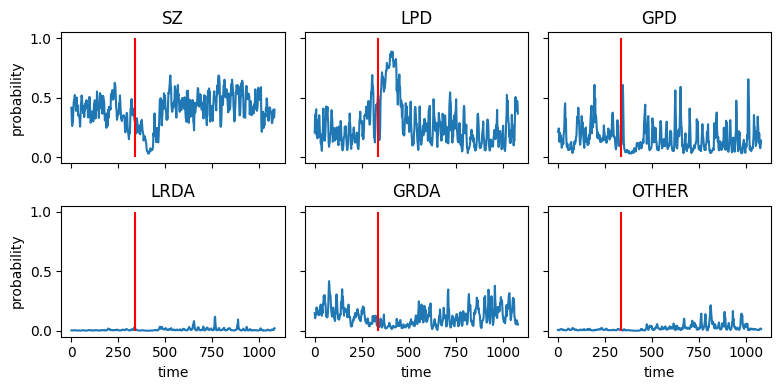

In [34]:
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
time = np.arange(0,unlabeled_score.shape[0]*2,2)
fig, axs = plt.subplots(2,3,figsize = (8,4),sharex=True,sharey=True)
titles = ['SZ','LPD','GPD','LRDA','GRDA','OTHER']
for i in range(6):
    axs[int(i/3),i-int(i/3)*3].plot(time,unlabeled_score[:,i])
    axs[int(i/3),i-int(i/3)*3].vlines(sz_row.onset-sz_row.start,0,1,colors=['r'])
    axs[int(i/3),i-int(i/3)*3].set_title(titles[i])
axs[0,0].set_ylabel('probability')
axs[1,0].set_ylabel('probability')
axs[1,0].set_xlabel('time')
axs[1,1].set_xlabel('time')
axs[1,2].set_xlabel('time')
plt.tight_layout()

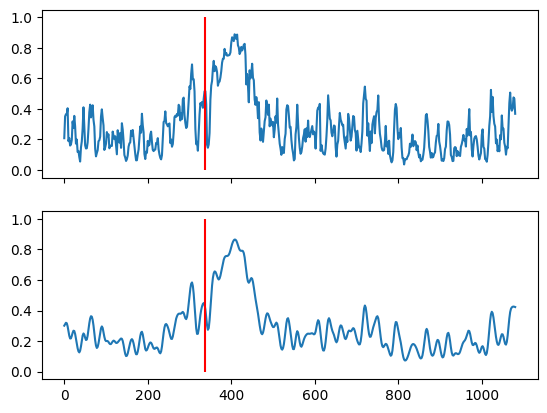

In [35]:
prob_filt = np.round(gaussian_filter1d(unlabeled_score[:,1],2*int(len(prob)/1000+1)),3)
time = np.arange(0,unlabeled_score.shape[0]*2,2)
fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(time,unlabeled_score[:,1])
axs[0].vlines(sz_row.onset-sz_row.start,0,1,colors=['r'])
axs[1].plot(time,prob_filt)
axs[1].vlines(sz_row.onset-sz_row.start,0,1,colors=['r'])

In [36]:
from utils_sparcnet import get_onset_and_spread
x = np.percentile(prob_filt[:int(prob_filt.shape[0])],85)
sz_prob_df = pd.DataFrame(prob_filt, columns=['sz_prob'])
sz_spread,sz_clf_smooth = get_onset_and_spread(sz_prob_df,threshold=x)
print('predicted:',sz_spread.values[0,0]*2)
print('true:', sz_row.onset-sz_row.start)
print(f'the predicted onset is {sz_spread.values[0,0]*2-(sz_row.onset-sz_row.start)} seconds later than the true onset')

predicted: 350
true: 336.375
the predicted onset is 13.625 seconds later than the true onset


# Perform on all data

In [ ]:
def predict(i, seizure_list, model_cnn):
	sz_row = seizure_list.iloc[i,:]
	print(f"Pulling seizure from {sz_row.patient}: {sz_row.fname} from {sz_row.start} to {sz_row.end}")
	sz_df, fs_raw = get_iEEG_data('joie1','/mnt/sauce/littlab/users/kuangzy/ieeglogin.bin',
                                sz_row.fname,sz_row.start*1e6,sz_row.end*1e6, 
                                select_electrodes=['C3', 'C4', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 'O1', 'O2', 'P3', 'P4', 'T3', 'T4', 'T5', 'T6'])
	sz_montage = preprocess(sz_df,fs_raw,
                			current_channel_order = ['C3', 'C4', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 'O1', 'O2', 'P3', 'P4', 'T3', 'T4', 'T5', 'T6'],
                            new_channel_order = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2'],
                            bipolar_channels = ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2'])
	sz_df = sz_montage.T
	N = int(sz_df.shape[1]/400)
	X3 = np.zeros((N-9,16,2000))
    #windows of length 10s and shift of 2s
	for n in range(N-9):
		start_sn = n*400
		end_sn = start_sn + 2000
		x = sz_df[:,start_sn:end_sn]
		X3[n,:,:] = x
	X = X3
	batch_size = 1000
	model_cnn.eval()
	(X_batch_list) = get_unlabeled_batch_list(X,batch_size)
	K = len(X_batch_list)
	S_list = list() 
	V_list = list()

	for k in range(K):
		'''if k%100 == 0:
			print (k)'''
		X = X_batch_list[k]
		X = torch.from_numpy(X).float()
		X = X.to(device)

		output, v = model_cnn(X)

		S_list.append(output.detach().to('cpu'))
		V_list.append(v.detach().to('cpu'))
	S2 = torch.cat(S_list,dim=0)
	prob = F.softmax(S2, 1)
	unlabeled_score = prob.numpy()
	prob = unlabeled_score[:,1]
	prob[0]=0
	prob[-1]=0
	prob_filt = gaussian_filter1d(prob,5*int(len(prob)/1000+1))
	x = np.percentile(prob_filt[:int(prob_filt.shape[0])],88)
	sz_prob_df = pd.DataFrame(prob_filt, columns=['sz_prob'])
	sz_spread,sz_clf_smooth = get_onset_and_spread(sz_prob_df,threshold=x)
	if len(sz_spread.values[0])!=0:
		print('predicted:',sz_spread.values[0,0]*2)
		print('true:', sz_row.onset-sz_row.start)
		print(f'the predicted onset is {sz_spread.values[0,0]*2-(sz_row.onset-sz_row.start)} seconds later than the true onset')
		return sz_spread.values[0,0]*2-(sz_row.onset-sz_row.start), prob
	else:
		print(f'{sz_row.fname} falied to predict onsets')
		return np.nan,prob

diff = []
probabilities = []
for i in range(seizure_list.shape[0]):
	print('-----------------------------------------------------------')
	latency, prob = predict(i, seizure_list, model_cnn)
	diff.append(latency)
	probabilities.append(prob)
with open("diff_sparcnet.txt", 'w') as f:
    for s in diff:
        f.write(str(s) + '\n')

-----------------------------------------------------------
Pulling seizure from EMU1061: EMU1061_Event_Day05_1 from 52550.78125 to 53644.527343
predicted: 348
true: 336.375
the predicted onset is 11.625 seconds later than the true onset
-----------------------------------------------------------
Pulling seizure from EMU1232: EMU1232_Event_Day01_1 from 54203.125 to 55183.589843
predicted: 334
true: 371.484375
the predicted onset is -37.484375 seconds later than the true onset
-----------------------------------------------------------
Pulling seizure from EMU1260: EMU1260_Event_Day03_1 from 9644.53125 to 10304.683593000002
predicted: 148
true: 141.984375
the predicted onset is 6.015625 seconds later than the true onset
-----------------------------------------------------------
Pulling seizure from EMU1289: EMU1289_Event_Day05_1 from 12863.28125 to 14457.027343000002
predicted: 276
true: 403.07031199999983
the predicted onset is -127.07031199999983 seconds later than the true onset
---

## Analysis

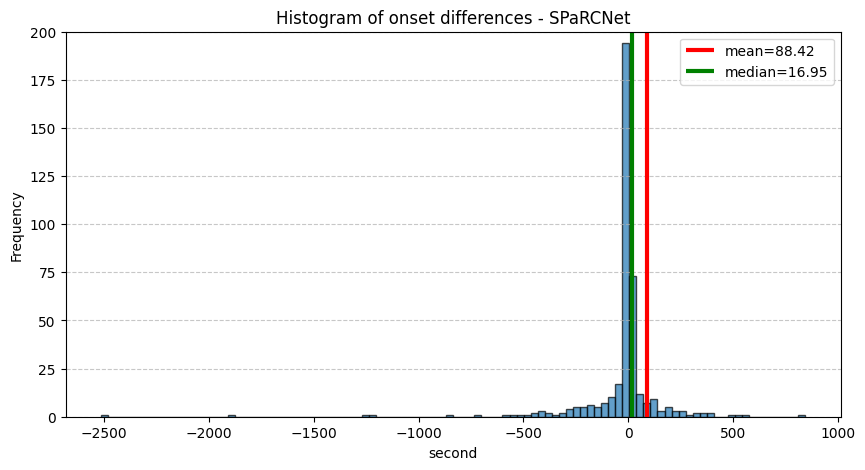

In [38]:
with open("diff_sparcnet.txt", 'r') as f: 
    diff = [float(line.rstrip('\n')) for line in f]

def plot_histogram(data, bins, title="Histogram of onset differences - SPaRCNet", xlabel="second", ylabel="Frequency"):
    mean_value = np.nanmean(np.abs(data))
    median_value = np.nanmedian(np.abs(data))
    plt.figure(figsize=(10, 5))
    counts, bin_edges, _ = plt.hist(data, bins=bins, edgecolor="black", alpha=0.7)
    #plt.xticks(bin_edges)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.vlines(np.nanmean(np.abs(data)),0,200,colors='r', linewidth= 3,label=f'mean={mean_value:.2f}')
    plt.vlines(np.nanmedian(np.abs(data)),0,200,colors='g',linewidth= 3,label=f'median={median_value:.2f}')
    plt.legend()
    plt.ylim(0,200)
    plt.show()
    

# Example usage
plot_histogram(diff, bins=100)

Text(0.5, 1.0, 'Normalized Confusion Matrix of SPaRCNet')

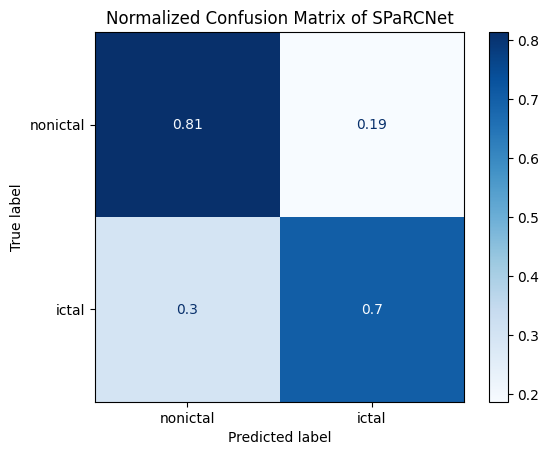

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true,predicted = [], []
for i in range(449):
    sz_row = seizure_list.iloc[i]
    length = sz_row.end - sz_row.start
    label = np.arange(len(probabilities[i]))
    on_idx = (sz_row.onset - sz_row.start)/2
    off_idx = (sz_row.offset - sz_row.start)/2
    true += [1 if l <= off_idx and l>=on_idx else 0 for l in label]
    predicted += [1 if p>=0.45 else 0 for p in probabilities[i]]

cm = confusion_matrix(true, predicted, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['nonictal','ictal'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix of SPaRCNet')